<a href="https://colab.research.google.com/github/89CANDY89/BOOTCAMP-2-ALURA/blob/main/PROJETO_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



#**NÚMEROS DA COVID 19 NO ESTADO DE MATO GROSSO DO RIO DE JANEIRO** 

##**Sobre este Estudo**

*Serão extraídos os dados da COVID 19 referente ao estado do Rio de Janeiro*

##**Bibliotecas**

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import seaborn as sns
import datetime as dt
import warnings
warnings.simplefilter(action='ignore')

from functools import reduce
from pandas.plotting import autocorrelation_plot
from fbprophet.diagnostics import cross_validation
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.plot import plot_cross_validation_metric
from sklearn.metrics import mean_absolute_error
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_plotly, plot_components_plotly


mpl.rcParams['figure.figsize'] = (16,10)
sns.set_style("white")

##**Importação dos Dados**

In [39]:
dados = pd.read_csv('https://raw.githubusercontent.com/89CANDY89/BOOTCAMP-2-ALURA/main/dados/obitos%20RJ.csv',
                    sep=",", thousands = ".", decimal = ";")

In [40]:
dados.isna().sum()

epidemiological_week                               0
date                                               0
order_for_place                                    0
state                                              0
city                                             486
city_ibge_code                                   470
place_type                                         0
last_available_confirmed                           0
last_available_confirmed_per_100k_inhabitants    549
new_confirmed                                      0
last_available_deaths                              0
new_deaths                                         0
last_available_death_rate                          0
estimated_population                             470
is_last                                            0
is_repeated                                        0
dtype: int64

Analisando os dados neste dataframe, decidi manter apenas alguns para utilizarmos no estudo. 


In [41]:
regioes_dic = {
            'Sudeste' : ['RJ'],
           }

regioes = []
for estado in dados['state']:
  for regiao, uf in regioes_dic.items():
    if estado in uf:
      regioes.append(regiao)
   
dados['regiao'] = regiao
dados['date'] = pd.to_datetime(dados['date'], format ='%Y-%m-%d')

In [42]:
dados_br = dados[['date','epidemiological_week', 'regiao','state','city','estimated_population',
                  'place_type','new_confirmed','new_deaths']]
dados_br.columns=['data','semana_epidemiologica','regiao','uf','cidade','populacao_estimada',
                  'tipo_local', 'casos_novos', 'obitos_novos']
dados_br.head()         

,data,semana_epidemiologica,regiao,uf,cidade,populacao_estimada,tipo_local,casos_novos,obitos_novos
0,2021-07-03,202126,Sudeste,RJ,Angra dos Reis,207044.0,city,0,0
1,2021-07-03,202126,Sudeste,RJ,Aperibé,11901.0,city,0,0
2,2021-07-03,202126,Sudeste,RJ,Araruama,134293.0,city,0,0
3,2021-07-03,202126,Sudeste,RJ,Areal,12669.0,city,0,0
4,2021-07-03,202126,Sudeste,RJ,Armação dos Búzios,34477.0,city,0,0


In [43]:
dados_ms = dados_br.query('uf =="RJ" and tipo_local =="state"')
dados_ms['casos_acumulados'] = dados_ms['casos_novos'].cumsum()
dados_ms['media_movel_casos'] = dados_ms['casos_novos'].rolling(window=14).mean()
dados_ms['obitos_acumulados'] = dados_ms['obitos_novos'].cumsum()
dados_ms['media_movel_obitos'] = dados_ms['obitos_novos'].rolling(window=14).mean()
dados_ms['obitosNovos7'] = dados_ms['obitos_novos'].shift(-7)
dados_ms['obitosNovos14'] = dados_ms['obitos_novos'].shift(-14)
dados_ms['obitosNovos21'] = dados_ms['obitos_novos'].shift(-21)
dados_ms['obitosNovos30'] = dados_ms['obitos_novos'].shift(-30)

dados_ms['ano'] = pd.DatetimeIndex(dados_ms.data).year
dados_ms['mes'] = pd.DatetimeIndex(dados_ms.data).month

**Funções de Plot**

In [48]:
def plotar_linha(x, y, df, titulo, ylabel, xlabel, label, yscale='linear'):
  plt.figure(figsize=(18,8))
  sns.lineplot(x=x, y=y, data=df, label=label.title(), linewidth=2)
  sns.despine(bottom=True, left=True)
  plt.yscale(yscale)
  plt.title(titulo.title(), fontsize=16, weight='bold', pad=20, loc='left')
  plt.ylabel(ylabel.title(), fontsize=14, weight='semibold')
  plt.xlabel(xlabel.title(), fontsize=14, weight='semibold')
  plt.legend(fontsize=14)
  plt.grid(alpha=.2)

##Início pandemia

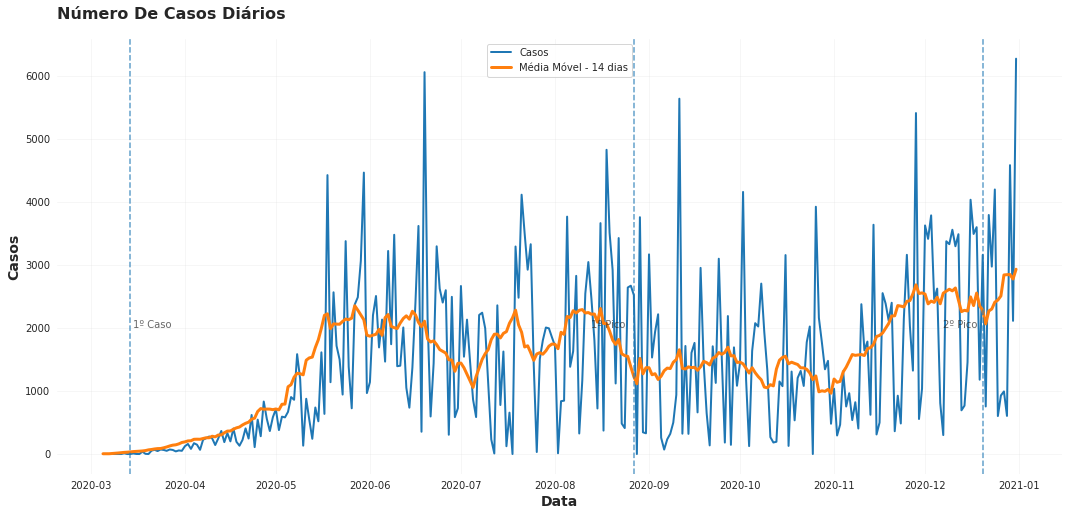

In [49]:
dados_ms_2020 = dados_ms.query('data < 2021')

plotar_linha(x='data',y='casos_novos',df=dados_ms_2020, titulo='Número de Casos Diários',
             ylabel='casos',xlabel='Data',label='casos')
ax = sns.lineplot(x='data', y='media_movel_casos', data=dados_ms_2020, label='Média Móvel - 14 dias', linewidth=3)
ax.axvline(x=dt.datetime(2020, 3, 14), linestyle='dashed', alpha=0.7)
ax.text(x=dt.datetime(2020, 3, 15), y=2010, s='1º Caso', alpha=0.7)
plt.axvline(dt.datetime(2020,8,27),ymin=0, ymax=1,linestyle='dashed',alpha=0.7)
plt.text(x=dt.datetime(2020, 8, 13), y=2010, s='1º Pico', alpha=0.7)
plt.axvline(dt.datetime(2020,12,20),ymin=0, ymax=1,linestyle='dashed',alpha=0.7)
plt.text(x=dt.datetime(2020, 12, 7), y=2010, s='2º Pico', alpha=0.7)
plt.show()

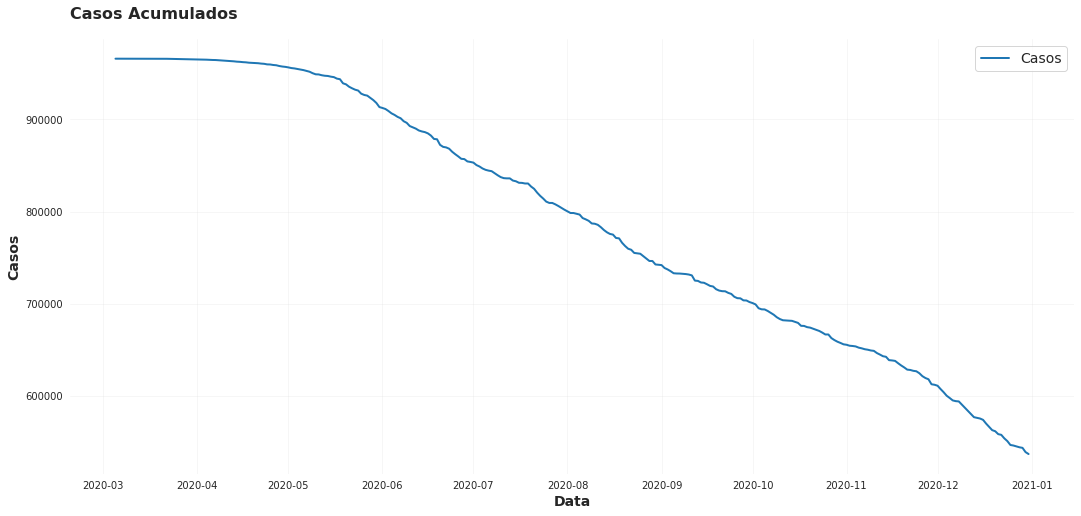

In [46]:
plotar_linha('data','casos_acumulados',dados_ms_2020, 'casos acumulados','casos', 'data', 'casos')

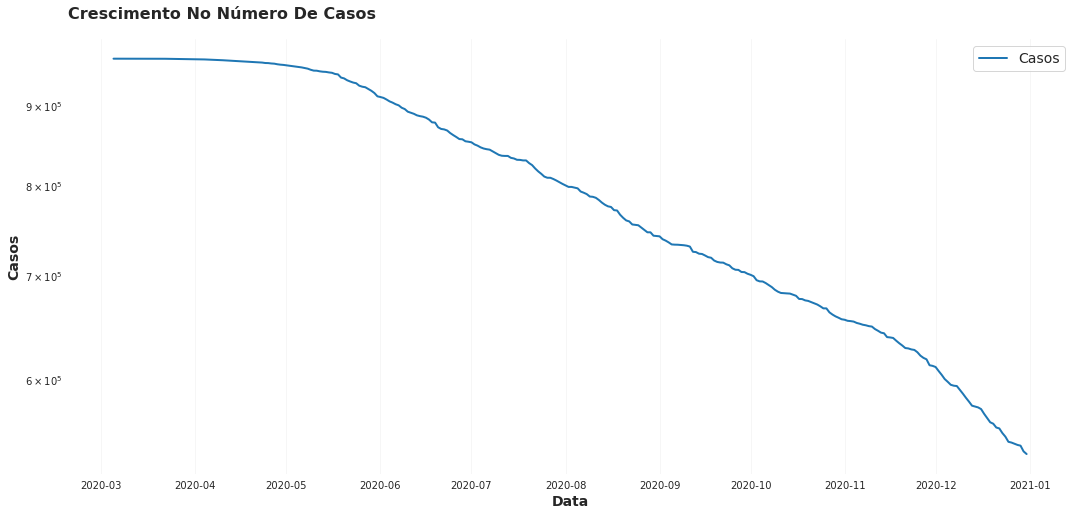

In [47]:
plotar_linha('data','casos_acumulados',dados_ms_2020,'crescimento no número de casos','casos','data','casos','log')

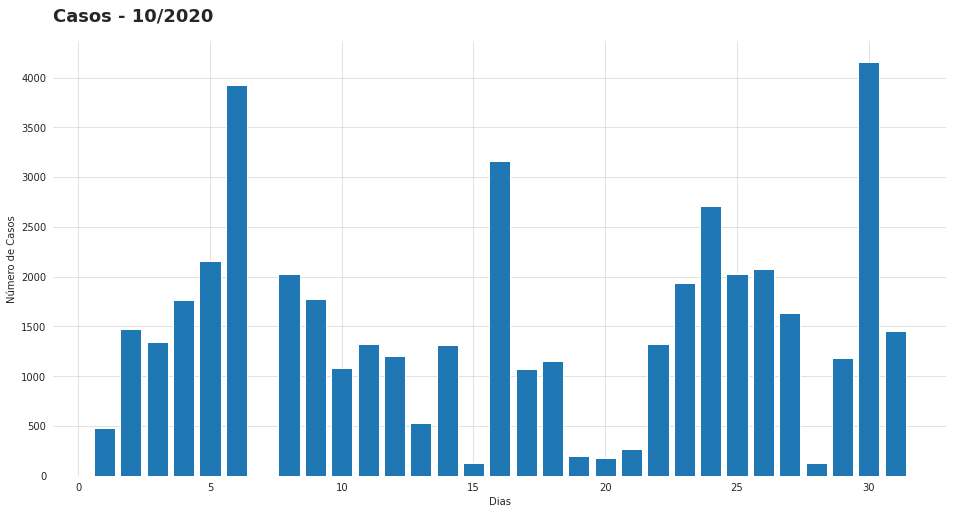

In [50]:
dados_ms_202010 = dados_ms_2020.query('mes == 10')

plt.figure(figsize=(16,8))
plt.bar(np.linspace(1,31,31), dados_ms_202010['casos_novos'])
plt.title('Casos - 10/2020', fontsize=18, loc='left', weight='bold', pad=20)
plt.xlabel('Dias')
plt.ylabel('Número de Casos')
sns.despine(bottom=True, left=True)
plt.grid(alpha=.7)
plt.show()

##Primeira Morte

No gráfico abaixo vamos visualizar os números dos óbitos no RIO DE JANEIRO.

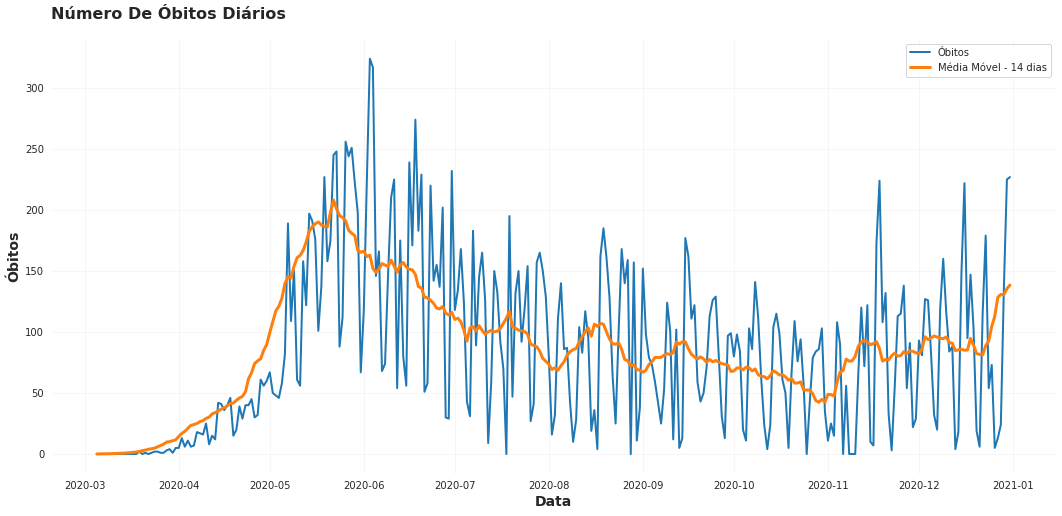

In [51]:
plotar_linha(x='data',y='obitos_novos',df=dados_ms_2020, titulo='Número de Óbitos Diários',
             ylabel='óbitos',xlabel='Data',label='óbitos')
ax = sns.lineplot(x='data', y='media_movel_obitos', data=dados_ms_2020, label='Média Móvel - 14 dias', linewidth=3)

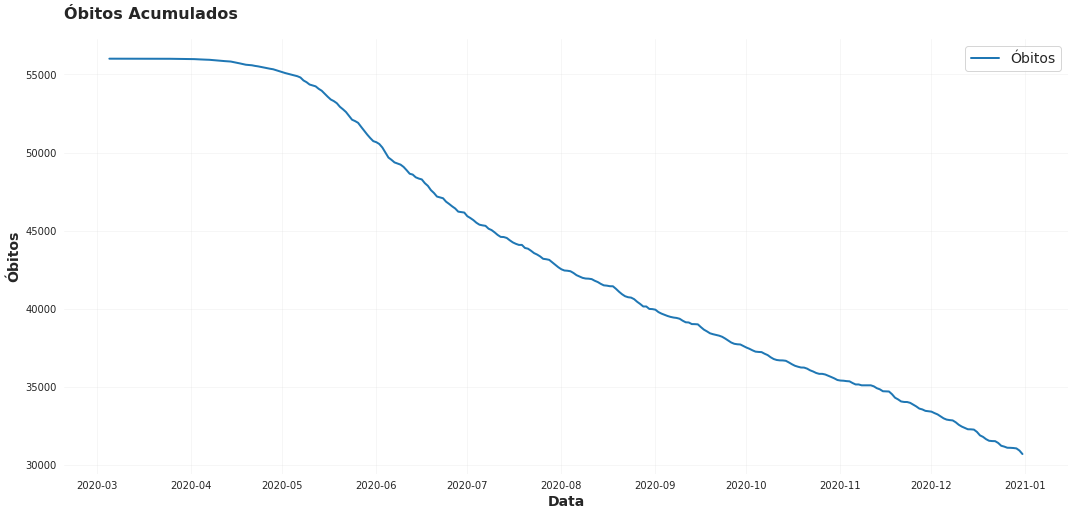

In [52]:
plotar_linha(x='data',y='obitos_acumulados',df=dados_ms_2020, titulo='Óbitos Acumulados',
             ylabel='óbitos',xlabel='Data',label='óbitos')

 **Correlação Entre Casos e Óbitos** 

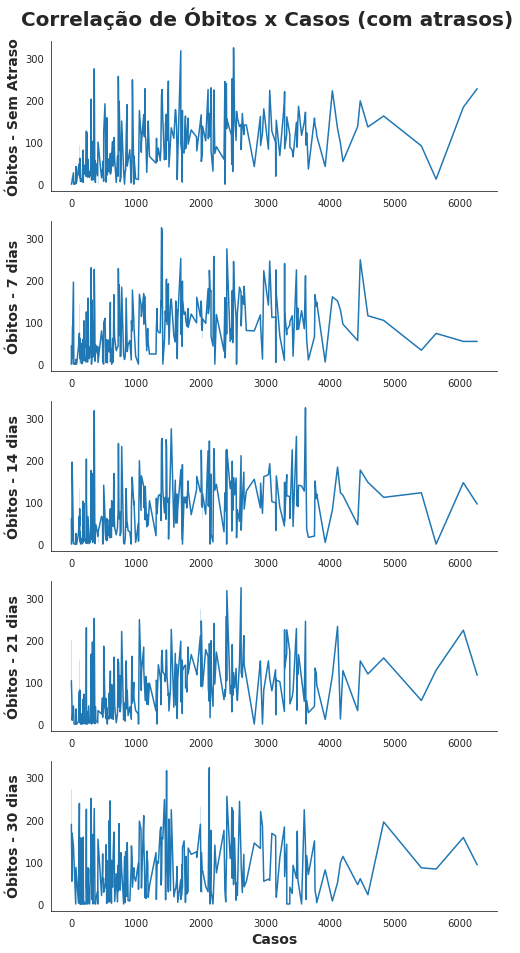

In [53]:
plt.figure(figsize=(8,16))
plt.subplots_adjust(hspace=.2)
plt.suptitle('Correlação de Óbitos x Casos (com atrasos)', weight='black', fontsize=20, y=0.91)

plt.subplot(5,1,1)
sns.lineplot(y='obitos_novos', x = 'casos_novos', data=dados_ms_2020)
sns.despine()
plt.ylabel('Óbitos - Sem Atraso', fontsize=14, weight='bold')
plt.xlabel('', fontsize=14, weight='bold')

plt.subplot(5,1,2)
sns.lineplot(y='obitosNovos7',x='casos_novos', data=dados_ms_2020)
sns.despine()
plt.ylabel('Óbitos - 7 dias', fontsize=14, weight='bold')
plt.xlabel('', fontsize=14, weight='bold')

plt.subplot(5,1,3)
sns.lineplot(y='obitosNovos14',x='casos_novos', data=dados_ms_2020)
sns.despine()
plt.ylabel('Óbitos - 14 dias', fontsize=14, weight='bold')
plt.xlabel('', fontsize=14, weight='bold')

plt.subplot(5,1,4)
sns.lineplot(y='obitosNovos21',x='casos_novos', data=dados_ms_2020)
sns.despine()
plt.ylabel('Óbitos - 21 dias', fontsize=14, weight='bold')
plt.xlabel('', fontsize=14, weight='bold')

plt.subplot(5,1,5)
sns.lineplot(y='obitosNovos30',x='casos_novos', data=dados_ms_2020)
sns.despine()
plt.ylabel('Óbitos - 30 dias', fontsize=14, weight='bold')
plt.xlabel('Casos', fontsize=14, weight='bold')

plt.show()

**Tabela de correlação entre Casos e Óbitos**

In [54]:
#Visualizando a correlação entre os dados de Casos e Óbitos
dados_corr = dados_ms_2020[['casos_novos','obitos_novos','obitosNovos7','obitosNovos14','obitosNovos21','obitosNovos30']].corr()
dados_corr

,casos_novos,obitos_novos,obitosNovos7,obitosNovos14,obitosNovos21,obitosNovos30
casos_novos,1.000000,0.522577,0.377109,0.389486,0.399982,0.100293
obitos_novos,0.522577,1.000000,0.740726,0.660717,0.570866,0.072065
obitosNovos7,0.377109,0.740726,1.000000,0.750075,0.658395,0.170035
obitosNovos14,0.389486,0.660717,0.750075,1.000000,0.748043,0.286145
obitosNovos21,0.399982,0.570866,0.658395,0.748043,1.000000,0.353407
obitosNovos30,0.100293,0.072065,0.170035,0.286145,0.353407,1.000000


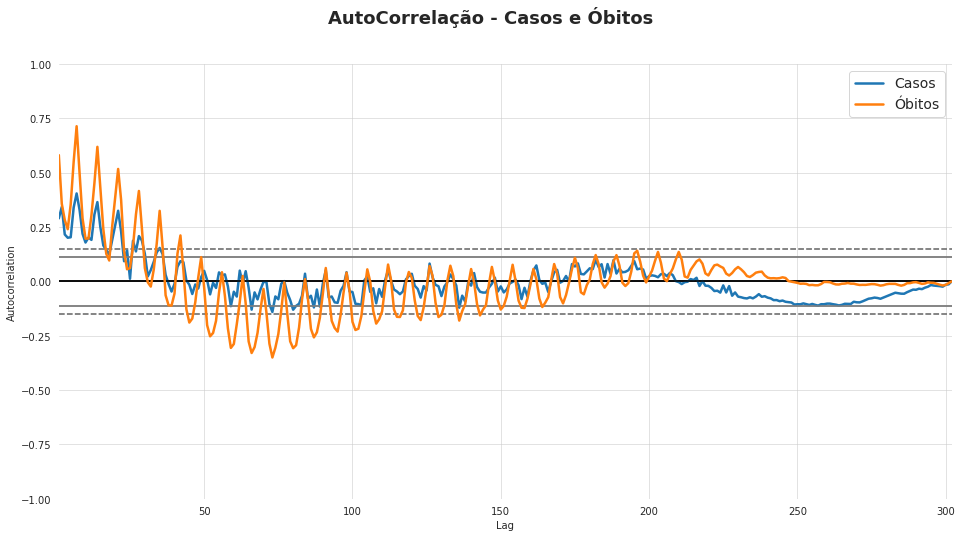

In [56]:
#Plotando autocorrelação - Casos e Óbitos
plt.figure(figsize=(16,8))
plt.suptitle('AutoCorrelação - Casos e Óbitos', fontsize=18, weight='bold')
autocorrelation_plot(dados_ms_2020['casos_novos'], linewidth=2.5, label='Casos')
autocorrelation_plot(dados_ms_2020['obitos_novos'], linewidth=2.5, label='Óbitos')
plt.legend(fontsize=14)
plt.grid(alpha=.7)
sns.despine(bottom=True, left=True)
plt.show()

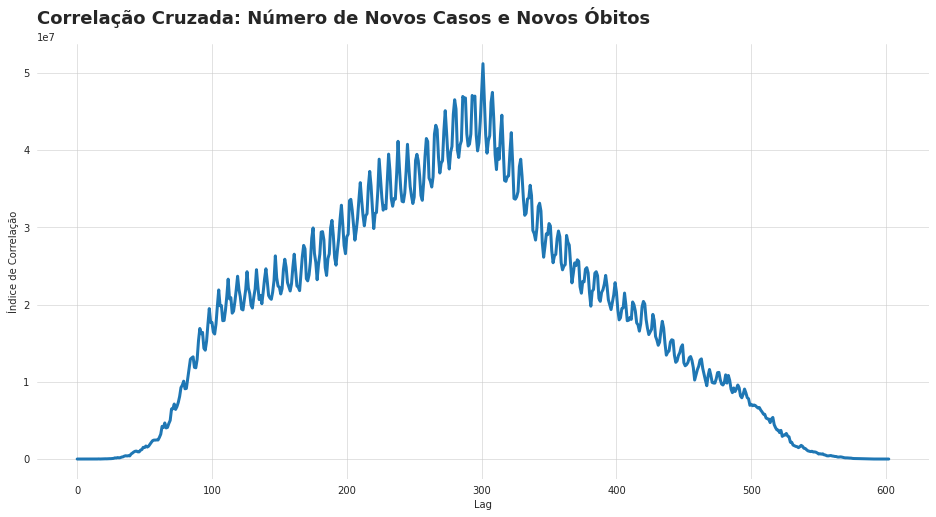

In [57]:
#Correlação Cruzada - Óbitos e Casos
plt.figure(figsize=(16,8))
plt.plot(np.correlate(dados_ms_2020['casos_novos'], dados_ms_2020['obitos_novos'], "full"), linewidth=3)
plt.ylabel('Índice de Correlação')
plt.xlabel('Lag')
plt.title('Correlação Cruzada: Número de Novos Casos e Novos Óbitos', fontsize=18, fontweight='bold', pad=20, loc='left')
sns.despine(bottom=True, left=True)
plt.grid(alpha=.7)
plt.show()

---
## **PROJEÇÃO**

In [58]:
dados_ms_2021 = dados_ms.query('ano == 2021')

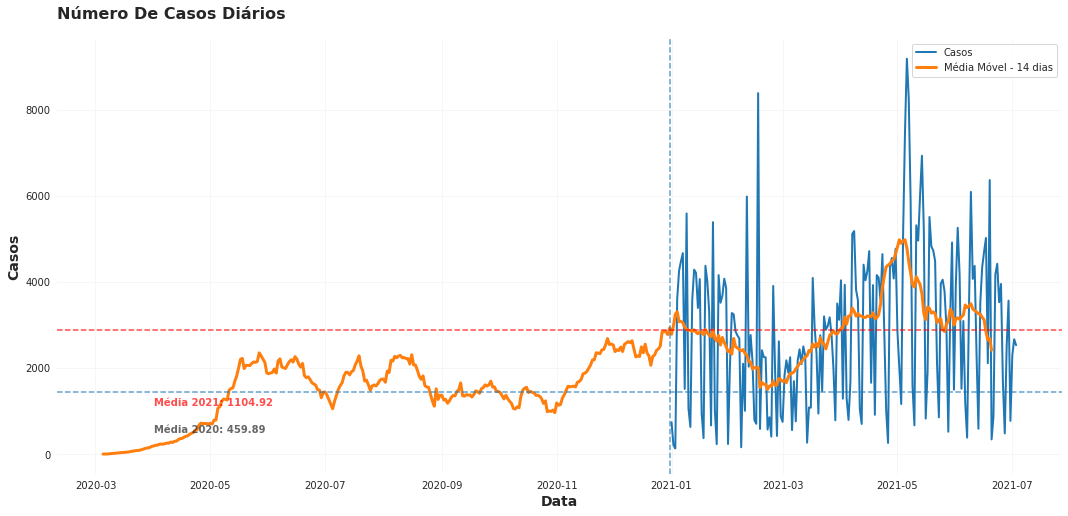

In [59]:
plotar_linha(x='data',y='casos_novos',df=dados_ms_2021, titulo='Número de Casos Diários',
             ylabel='casos',xlabel='Data',label='casos')
ax = sns.lineplot(x='data', y='media_movel_casos', data=dados_ms, label='Média Móvel - 14 dias', linewidth=3)
ax.axvline(x=dt.datetime(2020, 12, 31), linestyle='dashed', alpha=0.7)
plt.axhline(y=dados_ms_2020['casos_novos'].mean(), linestyle='dashed', alpha=0.7)
plt.text(x=dt.datetime(2020, 4, 1), y=500, s='Média 2020: 459.89', alpha=0.7,weight='semibold')
plt.axhline(y=dados_ms_2021['casos_novos'].mean(), linestyle='dashed', alpha=0.7, color='red')
plt.text(x=dt.datetime(2020, 4, 1), y=1120, s='Média 2021: 1104.92', alpha=0.7, color='red', weight='semibold')
plt.show()

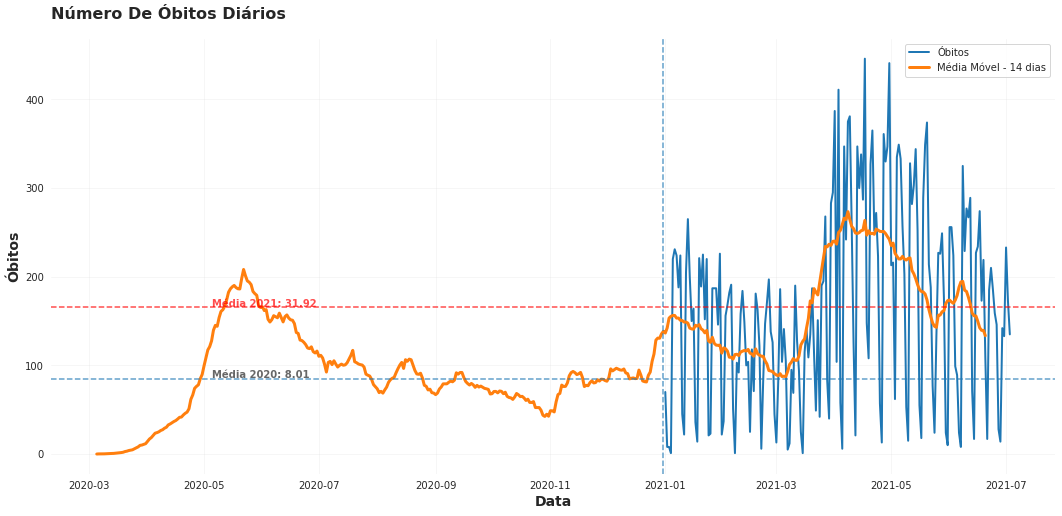

In [60]:
plotar_linha(x='data',y='obitos_novos',df=dados_ms_2021, titulo='Número de Óbitos Diários',
             ylabel='óbitos',xlabel='Data',label='Óbitos')
ax = sns.lineplot(x='data', y='media_movel_obitos', data=dados_ms, label='Média Móvel - 14 dias', linewidth=3)
ax.axvline(x=dt.datetime(2020, 12, 31), linestyle='dashed', alpha=0.7)
plt.axhline(y=dados_ms_2020['obitos_novos'].mean(), linestyle='dashed', alpha=0.7)
plt.text(x=dt.datetime(2020, 5, 5), y=dados_ms_2020['obitos_novos'].mean()+1, s='Média 2020: 8.01', alpha=0.7,weight='semibold')
plt.axhline(y=dados_ms_2021['obitos_novos'].mean(), linestyle='dashed', alpha=0.7, color='red')
plt.text(x=dt.datetime(2020, 5, 5), y=dados_ms_2021['obitos_novos'].mean()+1, s='Média 2021: 31.92', alpha=0.7, color='red', weight='semibold')
plt.show()

In [61]:
dados_corr = dados_ms_2021[['casos_novos','obitos_novos','obitosNovos7','obitosNovos14','obitosNovos21','obitosNovos30']].corr()
dados_corr

,casos_novos,obitos_novos,obitosNovos7,obitosNovos14,obitosNovos21,obitosNovos30
casos_novos,1.000000,0.663480,0.635335,0.547842,0.548915,-0.051314
obitos_novos,0.663480,1.000000,0.749849,0.718632,0.636877,-0.095213
obitosNovos7,0.635335,0.749849,1.000000,0.747148,0.722922,-0.020619
obitosNovos14,0.547842,0.718632,0.747148,1.000000,0.751597,0.013440
obitosNovos21,0.548915,0.636877,0.722922,0.751597,1.000000,0.114304
obitosNovos30,-0.051314,-0.095213,-0.020619,0.013440,0.114304,1.000000


##**ESTIMATIVA**

In [62]:
df = dados_ms[['data','casos_novos']]
df.columns = ['ds','y']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 486 entries, 93 to 42353
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      486 non-null    datetime64[ns]
 1   y       486 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 11.4 KB


In [63]:
modelo = Prophet(n_changepoints = 10, changepoint_prior_scale=10.0, seasonality_mode='multiplicative')
modelo.fit(df)
futuro = modelo.make_future_dataframe(periods=60, freq='D')
previsao = modelo.predict(futuro)
previsao.head()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2020-03-05,24.647267,-1501.834866,1533.466724,24.647267,24.647267,0.288135,0.288135,0.288135,0.288135,0.288135,0.288135,0.0,0.0,0.0,31.749002
1,2020-03-06,24.664176,-1358.765833,1482.097009,24.664176,24.664176,0.103780,0.103780,0.103780,0.103780,0.103780,0.103780,0.0,0.0,0.0,27.223824
2,2020-03-07,24.681086,-1522.400846,1499.411630,24.681086,24.681086,0.009054,0.009054,0.009054,0.009054,0.009054,0.009054,0.0,0.0,0.0,24.904553
3,2020-03-08,24.697995,-1519.796704,1454.664493,24.697995,24.697995,-0.502047,-0.502047,-0.502047,-0.502047,-0.502047,-0.502047,0.0,0.0,0.0,12.298431
4,2020-03-09,24.714905,-1392.839265,1442.406364,24.714905,24.714905,-0.509706,-0.509706,-0.509706,-0.509706,-0.509706,-0.509706,0.0,0.0,0.0,12.117572


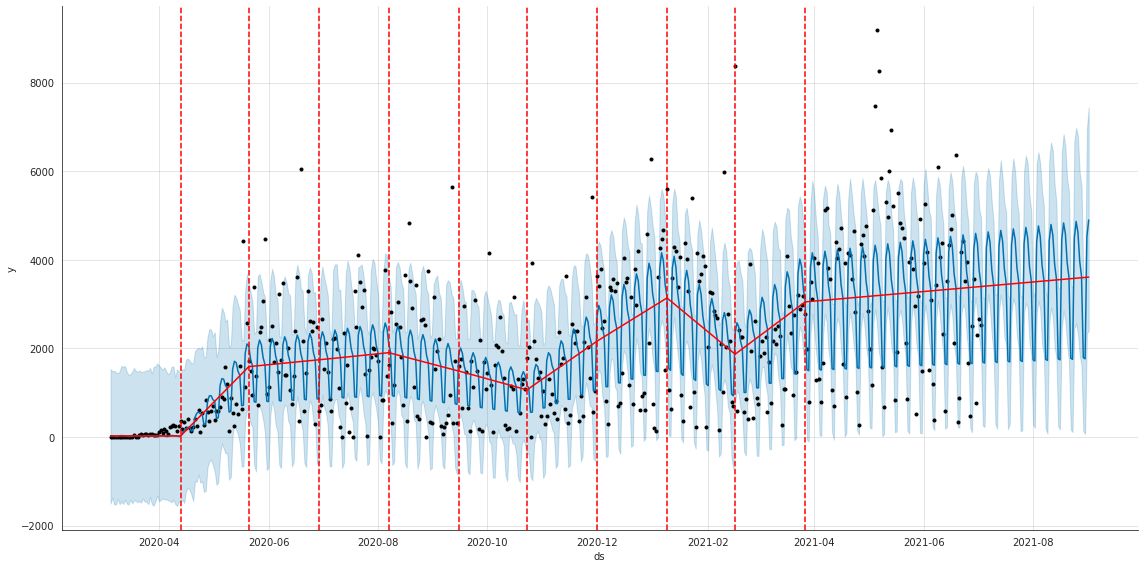

In [64]:
fig=modelo.plot(previsao, uncertainty=True, figsize=(16,8));
a=add_changepoints_to_plot(fig.gca(),modelo,previsao,cp_color='r')

sns.despine()
plt.show()

No gráfico acima temos alguns elementos interessantes a serem citados:
- A **linha azul escura** trata-se dos dados da **previsão** realizada pelo FBProphet;
- A faixa em **azul mais claro** seria como uma **margem de confiança**;
- Os **pontos pretos** representam os **dados reais**;
- A **linha tracejada em vermelho** representam em **mudança na tendência** do gráfico, e a **linha vermelha** no centro a **tendência** .
- Os **'+' em vermelho** referem-se aos **dados reais** utilizados como teste.

Após o plot dos componentes desta previsão, vamos fazer ajustes no gráfico, tirando os outliers à margem de confiança.

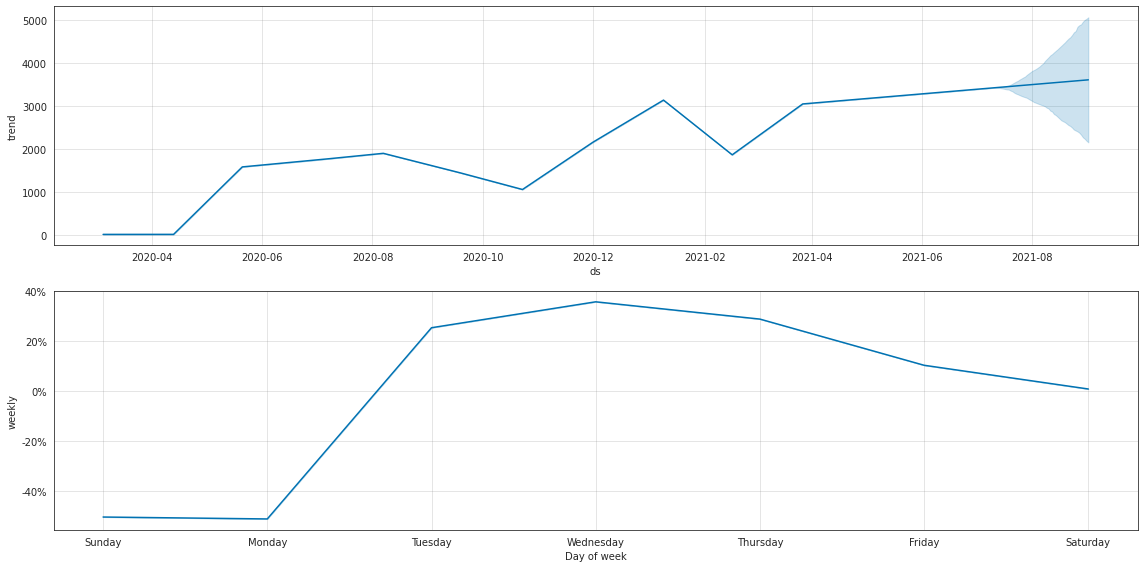

In [65]:
modelo.plot_components(previsao, figsize=(16,8));
plt.show()

Acima possuimos 2 gráficos:
- **Tendência**: Confirma o que vimos durante este projeto. Apresenta uma tendência de **alta**;
- **Sazonalidade Semanal**: Anteriomente chegamos a a questionar sobre a sazonalidade na notificação no número de casos. Percebemos que essas notificações **são baixas no Sábado e Domingo, e altas nos dias úteis da semana** .


In [66]:
novo_y = df.reset_index()  df_ajustado = novo_y[(novo_y['y'] > previsao['yhat_lower'][:464]) & (novo_y['y'] < previsao['yhat_upper'][:464])]

In [68]:
df_ajustado = novo_y[(novo_y['y'] > previsao['yhat_lower'][:464]) & (novo_y['y'] < previsao['yhat_upper'][:464])]

In [ ]:
df_ajustado.head()

,index,ds,y
0,896571,2020-03-14,2
1,896573,2020-03-15,0
2,896575,2020-03-16,2
3,896577,2020-03-17,2
4,896579,2020-03-18,1


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


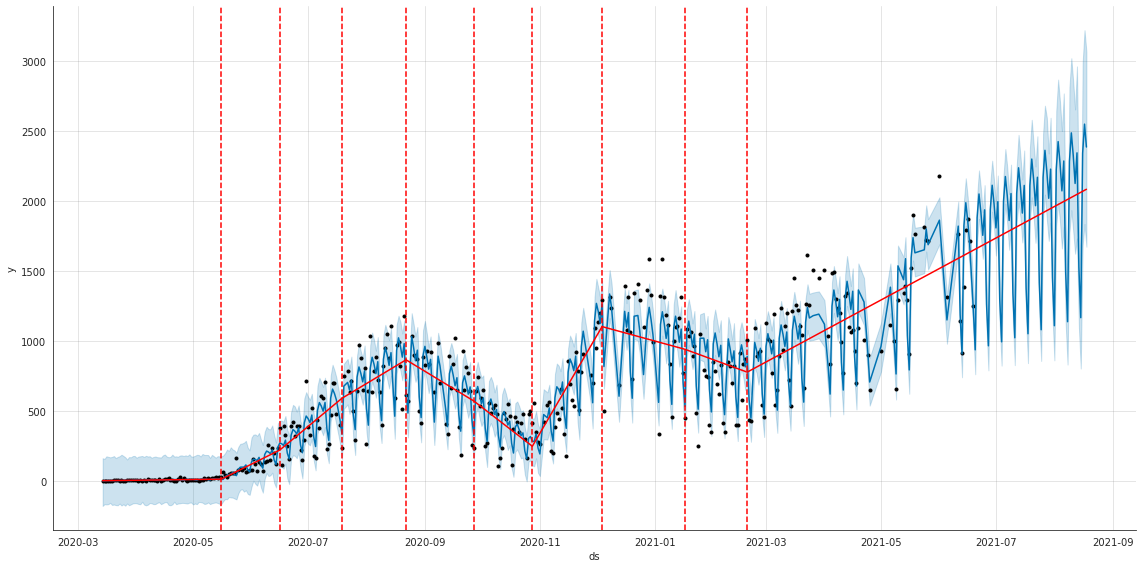

In [ ]:
modelo2 = Prophet(n_changepoints = 10, changepoint_prior_scale=10.0, seasonality_mode='multiplicative')
modelo2.fit(df_ajustado)
futuro2 = modelo2.make_future_dataframe(periods=60, freq='D')
previsao2 = modelo2.predict(futuro2)

fig=modelo2.plot(previsao2, uncertainty=True, figsize=(16,8));
a=add_changepoints_to_plot(fig.gca(),modelo2,previsao2,cp_color='r')

sns.despine()
plt.show()

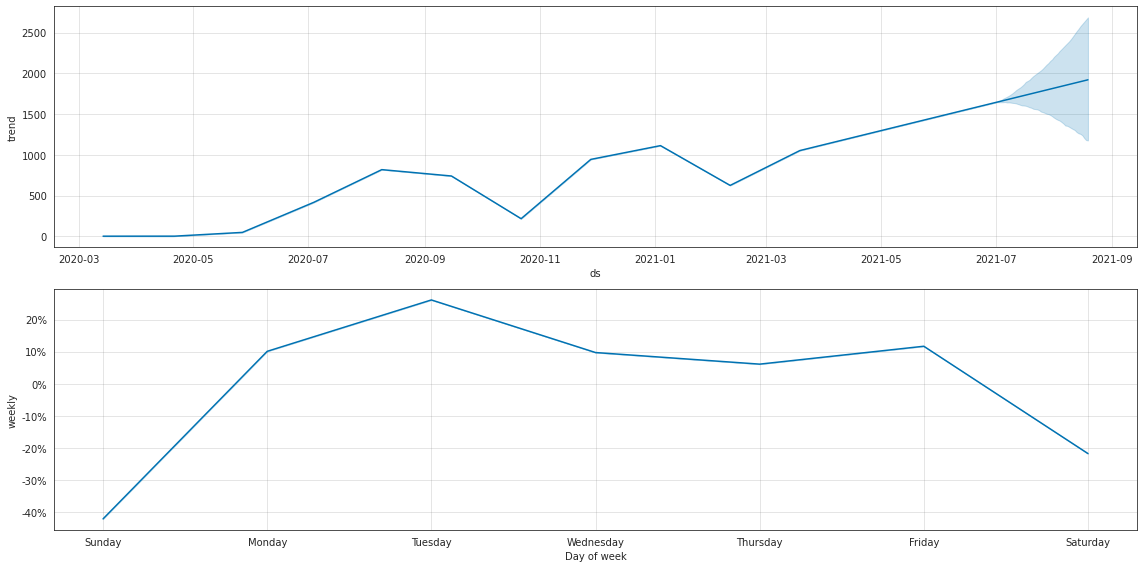

In [ ]:
modelo.plot_components(previsao, figsize=(16,8));

**Validação Cruzada dos Dados**

In [ ]:
df_cv = cross_validation(modelo2, initial = "360 days", horizon='30 days', 
                         period='30 days')

INFO:fbprophet:Making 3 forecasts with cutoffs between 2021-03-21 00:00:00 and 2021-05-20 00:00:00


In [ ]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2021-03-22,986.356907,805.602257,1173.742832,1265,2021-03-21
1,2021-03-23,1003.800971,834.967154,1162.435366,1616,2021-03-21
2,2021-03-24,967.977302,801.489674,1140.448525,1256,2021-03-21
3,2021-03-26,985.121122,806.996807,1172.224516,1507,2021-03-21
4,2021-03-29,976.182255,792.395824,1148.455826,1450,2021-03-21


In [ ]:
cutoff = df_cv['cutoff'].unique()

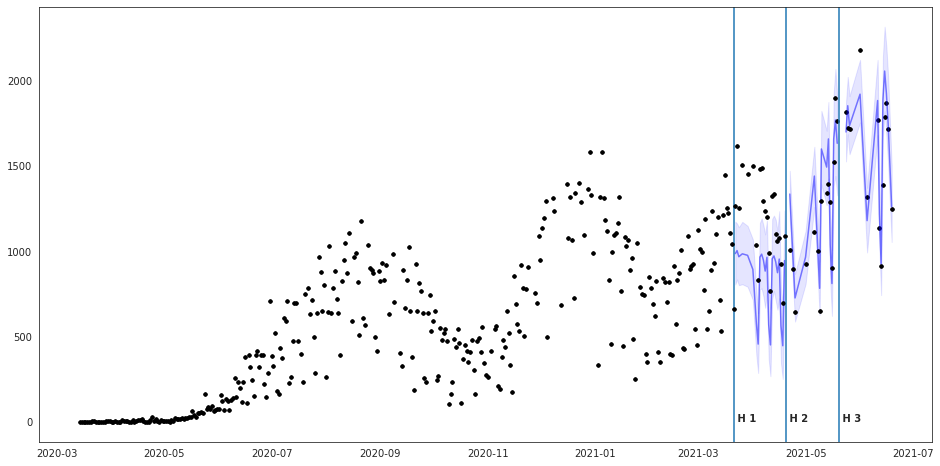

In [ ]:
plt.figure(figsize=(16,8))
x=1
for i in cutoff:
  
  df_cv_cut = df_cv[df_cv['cutoff'].values == i]

  ax = plt.plot(modelo2.history['ds'].values, modelo2.history['y'], 'k.')
  plt.plot(df_cv_cut['ds'].values, df_cv_cut['yhat'], ls='-', color='blue', alpha=.5)
  plt.fill_between(df_cv_cut['ds'].values, df_cv_cut['yhat_lower'], 
                  df_cv_cut['yhat_upper'], color='blue', alpha=.1)
  plt.axvline(x=pd.to_datetime(i))
  plt.text(x=pd.to_datetime(i),y=0, s=' H '+str(x),rotation=0, weight='bold')
  x +=1

In [ ]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,4 days,116174.654972,340.844033,276.225586,0.207779,0.229317,0.400000
1,5 days,62157.083940,249.313225,176.943087,0.129877,0.076317,0.800000
2,6 days,60769.898672,246.515514,166.135739,0.122068,0.076317,0.800000
3,8 days,104187.691521,322.781182,245.717627,0.177060,0.123150,0.600000
4,11 days,139176.420304,373.063561,278.044679,0.194323,0.326771,0.533333
5,12 days,132555.580874,364.081833,280.389476,0.181470,0.117658,0.400000
6,13 days,174912.234059,418.225100,368.158885,0.267774,0.326771,0.200000
7,14 days,158070.673882,397.581028,348.307406,0.292566,0.405264,0.200000
8,15 days,174509.078518,417.742838,386.882437,0.317361,0.405264,0.100000
9,16 days,157613.253789,397.005357,371.869875,0.306930,0.339341,0.200000


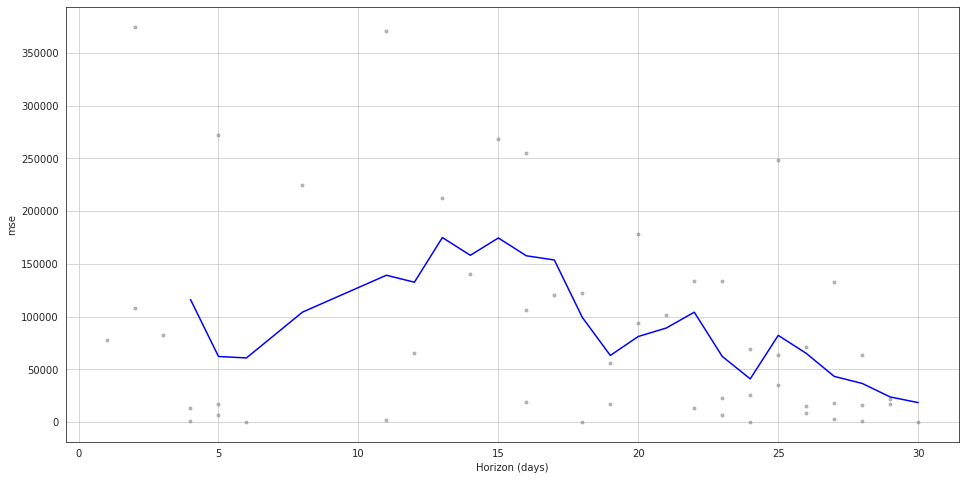

In [ ]:
plot_cross_validation_metric(df_cv, metric='mse',figsize=(16,8));

---
## **CONCLUSÃO**

As projeções são de establidade de obitos por causa da vacinação, mas outras variantes do virus podem distorcer as mesmas


---
## **REFERÊNCIAS**


- Brasil.io - https://brasil.io/dataset/covid19/caso_full/
- Coronavírus Brasil - https://covid.saude.gov.br/
- Wikipedia - https://pt.wikipedia.org/wiki/Campo_Grande
- Saúde MS - https://www.saude.ms.gov.br/informacoes-covid-19/paineis/
- Vacinometro MS - https://mais.saude.ms.gov.br/vacinometro/index.html
- https://github.com/marcelobin/BootCamp-Data-Science---Alura/blob/main/Projeto%20-%20M%C3%B3dulo%203%20-%20S%C3%A9ries%20Temporais/Projeto_M%C3%B3dulo_3_S%C3%A9ries_Temporais%20(1).ipynb